In [4]:
!which python3

/Library/Frameworks/Python.framework/Versions/3.11/bin/python3


In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# these are just couple extensions to help with certain things

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Standard imports
import os

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import cross_val_predict
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier


from imblearn.over_sampling import RandomOverSampler, SMOTE
# - RandomOverSampler: Duplicate random records from the minority class to balance the dataset.
# - SMOTE (Synthetic Minority Over-sampling Technique): Create synthetic examples of the minority class.

from imblearn.under_sampling import RandomUnderSampler
# Randomly remove samples from the majority class to balance the class distribution.

# Local imports

In [7]:
sns.set() # this will make the notebook use seaborn plotting styles

# Load Data

In [8]:
data = pd.read_csv('loan_default.csv')

In [9]:
data.columns

Index(['LoanID', 'Age', 'Income', 'LoanAmount', 'CreditScore',
       'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm',
       'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus',
       'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner',
       'Default'],
      dtype='object')

In [10]:
data.isnull().sum().sum()
# As we can see, there are no missing values in the dataset.

0

In [11]:
data.duplicated().sum()
# As we can see, there are no duplicated rows in the dataset.

0

In [12]:
data.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [13]:
unemployed_data = data[data['EmploymentType'] == 'Unemployed']
unemployed_data

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0
5,A9S62RQ7US,25,90298,90448,720,18,2,22.72,24,0.10,High School,Unemployed,Single,Yes,No,Business,Yes,1
6,H8GXPAOS71,38,111188,177025,429,80,1,19.11,12,0.16,Bachelor's,Unemployed,Single,Yes,No,Home,Yes,0
10,IA35XVH6ZO,28,140466,163781,652,94,2,9.08,48,0.23,High School,Unemployed,Married,No,No,Education,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255326,FYGOB527WK,48,44894,202276,473,10,3,7.32,48,0.26,High School,Unemployed,Single,No,Yes,Auto,No,0
255329,QXBHNXNA9X,34,53658,187245,847,35,3,3.08,48,0.85,High School,Unemployed,Single,Yes,Yes,Auto,Yes,0
255333,BM4B25R7EI,22,45575,43355,545,99,1,21.86,12,0.52,PhD,Unemployed,Married,Yes,Yes,Education,No,1
255335,OQ99DN6JL4,41,124446,249800,650,60,4,3.32,24,0.21,High School,Unemployed,Single,Yes,No,Other,No,0


In [14]:
data['Default'].value_counts()
# As we can see, the dataset is imbalanced. The number of non-defaulted loans is much higher than the number of defaulted loans.
# We will use the RandomOverSampler to balance the dataset.
# We will also use the SMOTE to balance the dataset.
# We will also use the RandomUnderSampler to balance the dataset.

Default
0    225694
1     29653
Name: count, dtype: int64

In [15]:
data['Default'].value_counts()
data['Default'].value_counts(normalize=True)
sampled_data = data.sample(n=500, random_state=5)

In [16]:
data.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


# Visualize the data using various plots

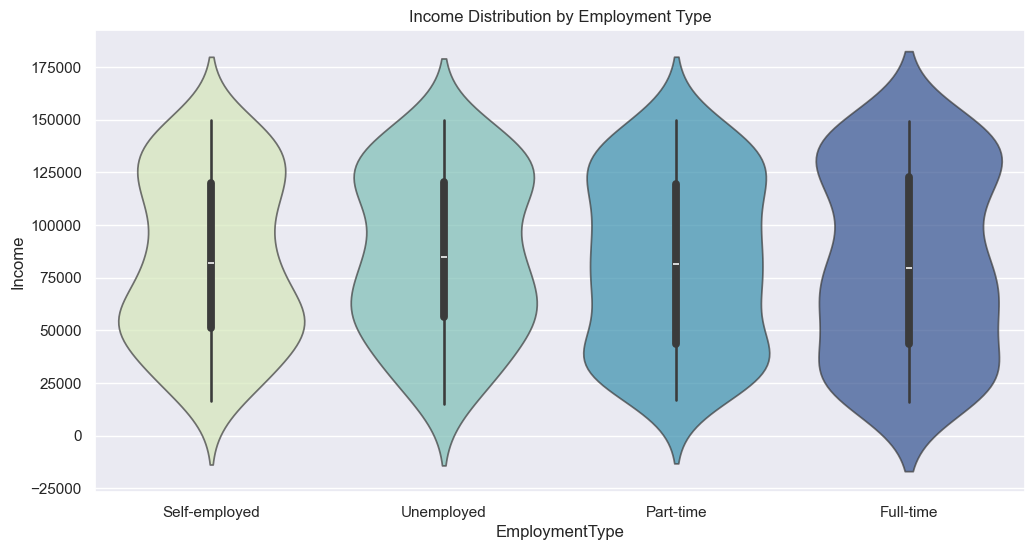

In [17]:
# Plotting the distribution of income by employment type using violin plot on the entire dataset

plt.figure(figsize=(12, 6))
sns.violinplot(x='EmploymentType', y='Income', data=sampled_data, hue='EmploymentType', palette='YlGnBu', alpha=0.7)
plt.title('Income Distribution by Employment Type')
plt.show()

### Income Distribution by Employment Type - Key Takeaways

1. **Employment Categories**:
   - Full-Time it mostly shows consistent income with some high income outliers
   - Part-Time is showing the most consistency around median income
   - Self-Employed has the most inconsistency with many low income outliers
   - Unemployed is also showing inconsistency with high income outliers

2. **Distribution Patterns:**
   - Full-Time: Shows concentrated distribution with some high-income outliers
   - Part-Time: Narrower distribution, indicating more consistent income levels
   - Self-Employed: Widest spread, suggesting high income variability
   - Unemployed: Also with spread showing income variability

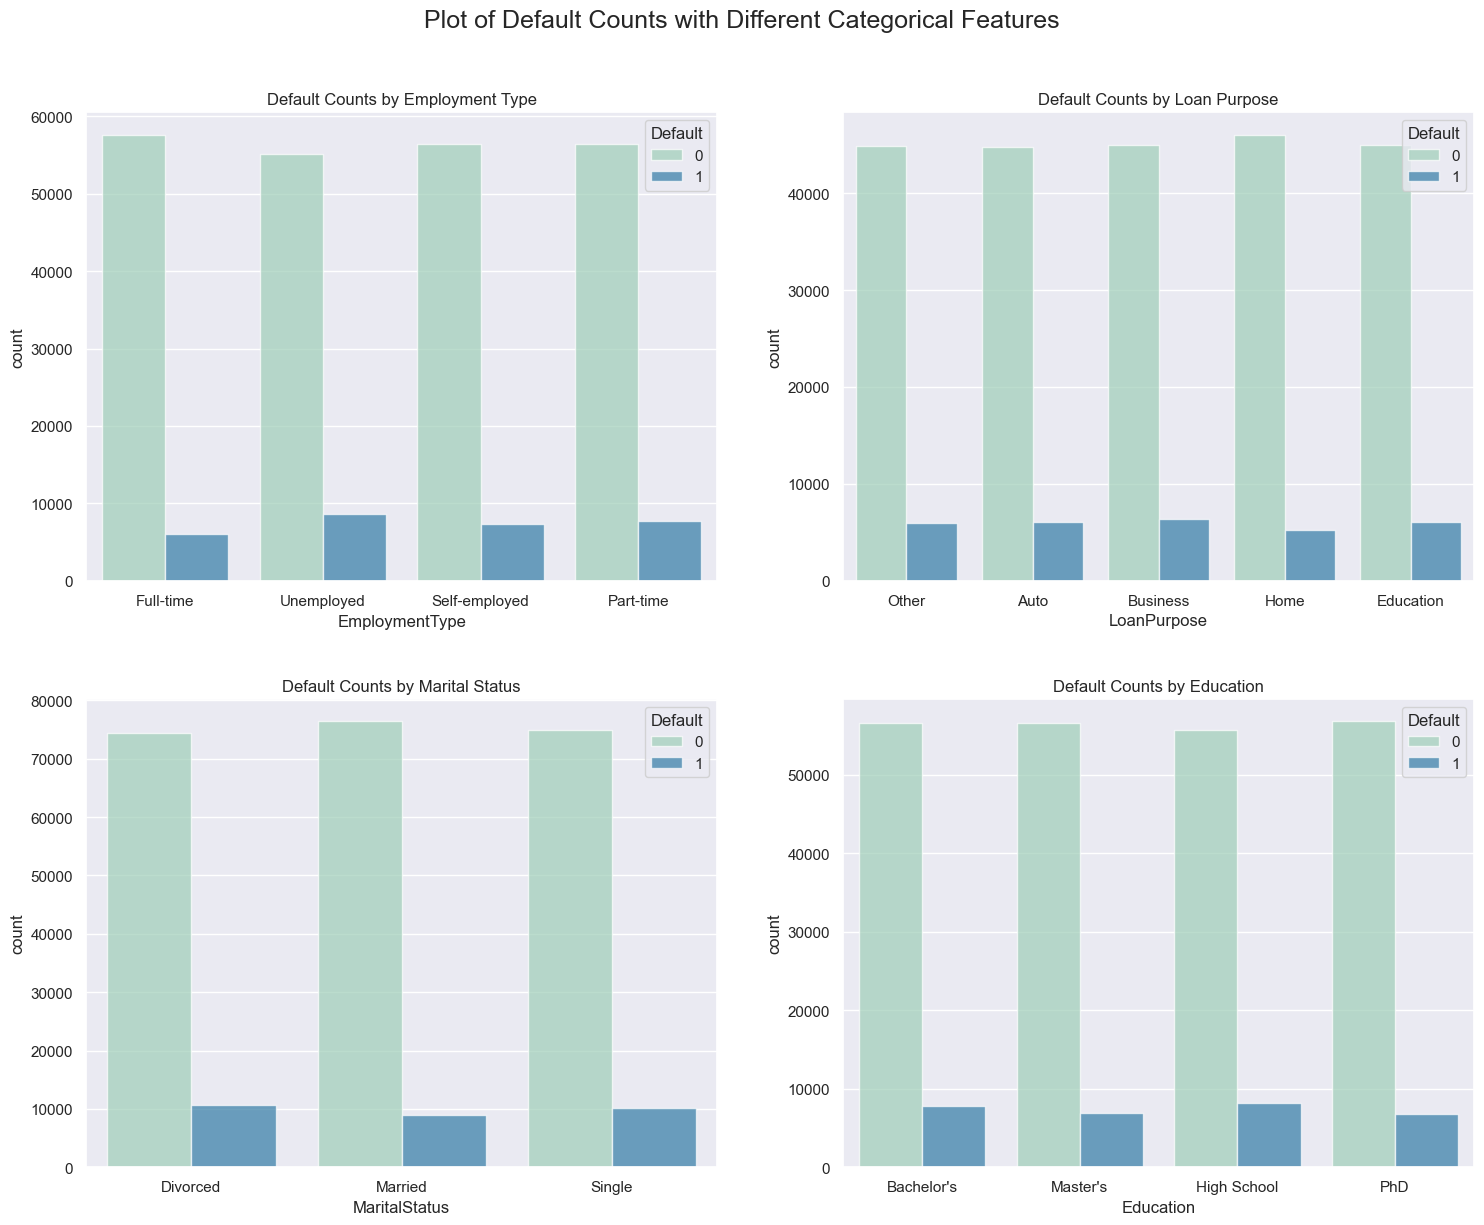

In [18]:
# Plotting the default counts with different categorical features

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Plot of Default Counts with Different Categorical Features', fontsize=18, y=1.02)

sns.countplot(x='EmploymentType', hue='Default', data=data, palette='YlGnBu', alpha=0.7, ax=axes[0, 0])
axes[0,0].set_title('Default Counts by Employment Type')

sns.countplot(x='LoanPurpose', hue='Default', data=data, palette='YlGnBu', alpha=0.7, ax=axes[0, 1])
axes[0,1].set_title('Default Counts by Loan Purpose')

sns.countplot(x='MaritalStatus', hue='Default', data=data, palette='YlGnBu', alpha=0.7, ax=axes[1, 0])
axes[1,0].set_title('Default Counts by Marital Status')

sns.countplot(x='Education', hue='Default', data=data, palette='YlGnBu', alpha=0.7, ax=axes[1, 1])
axes[1,1].set_title('Default Counts by Education')

plt.tight_layout(w_pad=3, h_pad=3)
plt.show()

### Default Analysis by Categories - Key Insights

#### Employment Status
- **Full-Time**: Largest group, lowest default rate (safest borrowers)
- **Part-Time**: Moderate volume, higher defaults than full-time
- **Self-Employed**: Higher risk, significant default proportion
- **Unemployed**: Smallest group but highest default rate

#### Loan Purpose
- **Personal/Business**: Most common, moderate to high default risk
- **Education**: Lower volume but better repayment rate
- **Home**: Good volume with lower default rate (secured loans)

#### Marital Status
- **Married**: Largest group, lower defaults (more stable)
- **Single**: Higher default risk than married
- **Divorced**: Smallest group but highest default rate

#### Education Level
- **Bachelor's/Master's**: Majority of loans, moderate default risk
- **High School**: Higher default proportion
- **PhD**: Smallest group but lowest default rate

*Risk Assessment Insight: Employment stability, education level, and marital status are key risk indicators.*

<Figure size 1200x6000 with 0 Axes>

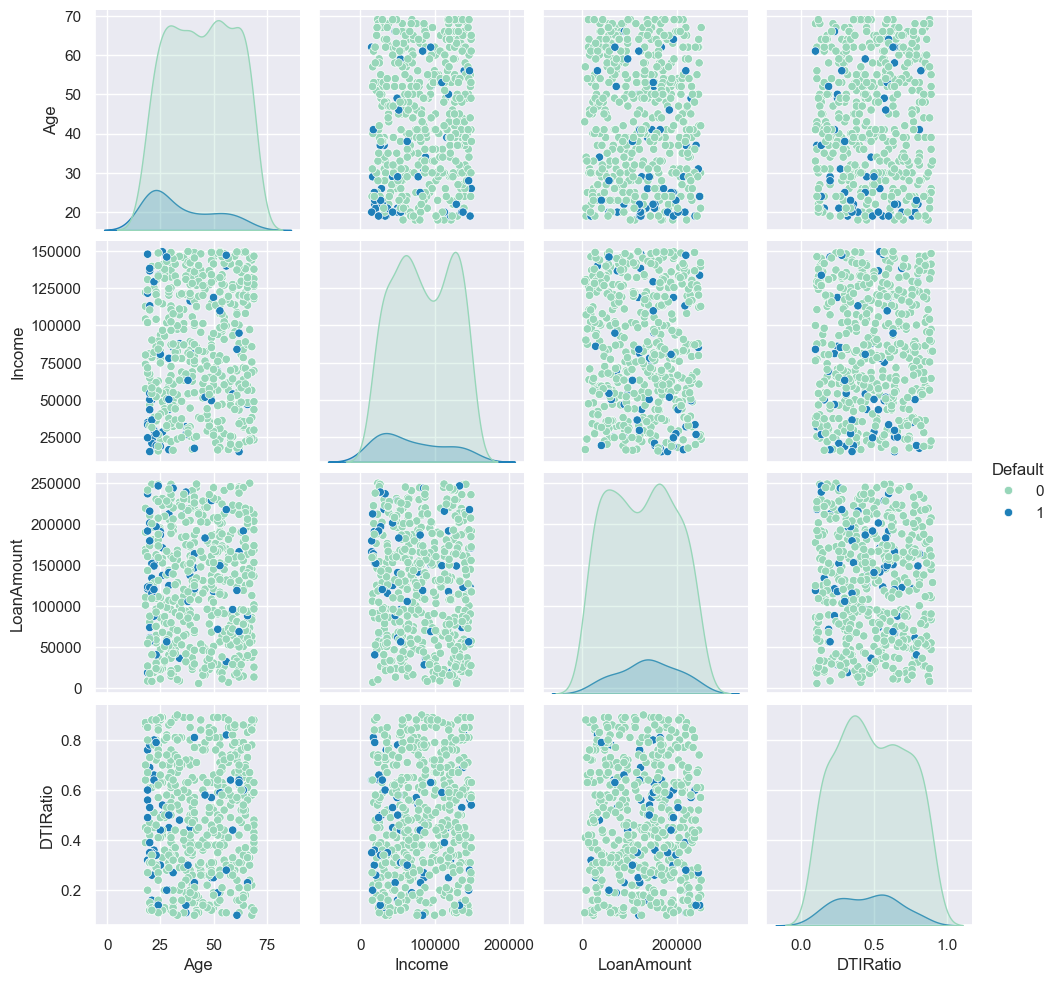

In [19]:
# Grid of relationships between numerical variables
plt.figure(figsize=(12, 60))
sns.pairplot(sampled_data[['Age', 'Income', 'LoanAmount', 'DTIRatio', 'Default']], diag_kind='auto', hue='Default', palette='YlGnBu')
plt.show()

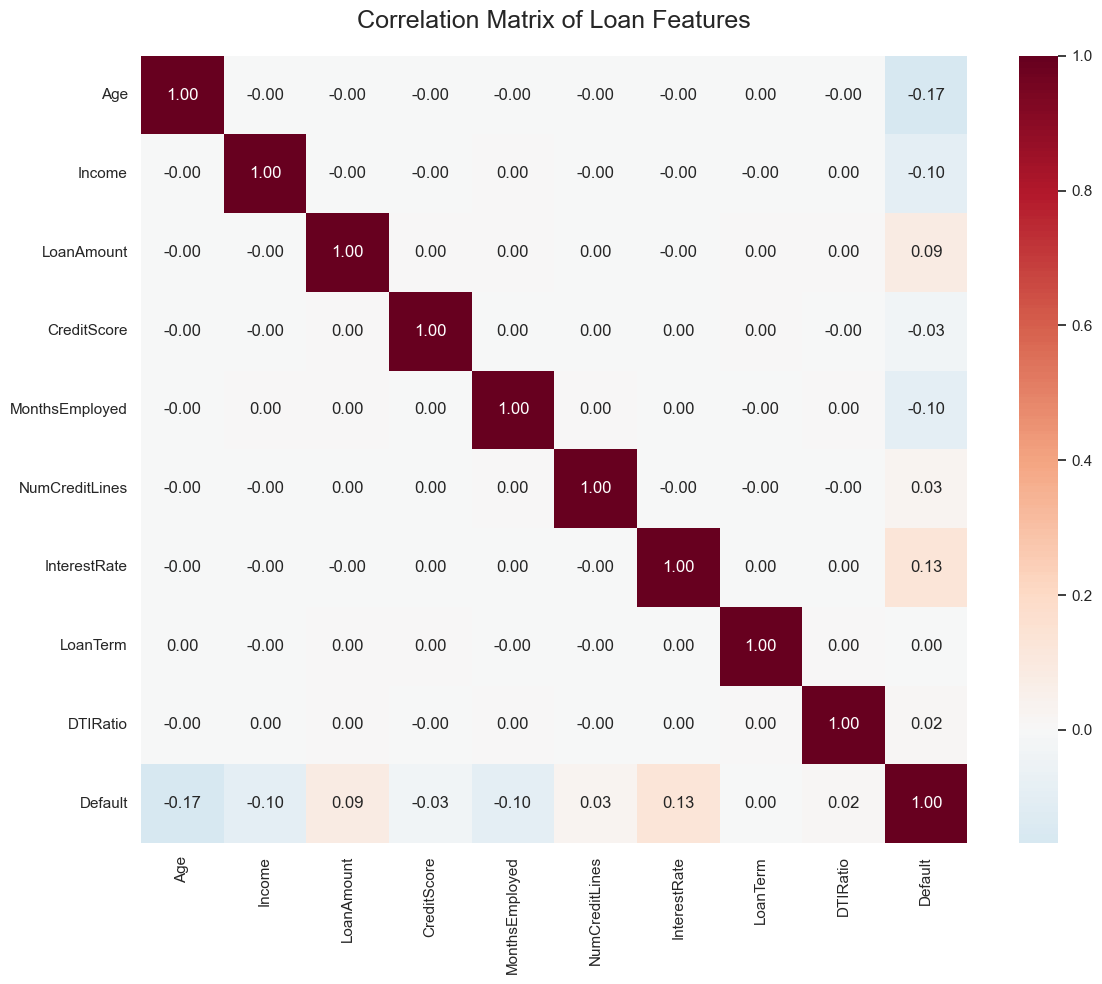

Correlation between Numerical Features and Default: 
Default           1.000000
Age               0.167783
InterestRate      0.131273
Income            0.099119
MonthsEmployed    0.097374
LoanAmount        0.086659
CreditScore       0.034166
NumCreditLines    0.028330
DTIRatio          0.019236
LoanTerm          0.000545
Name: Default, dtype: float64


In [20]:
# Plotting the heatmap of the correlation matrix of different numerical features

plt.figure(figsize=(12, 10))

sns.heatmap(data.corr(numeric_only=True), annot=True,fmt='.2f',cmap='RdBu_r',center=0)

plt.title('Correlation Matrix of Loan Features', pad=20, fontsize=18)

plt.tight_layout()
plt.show()

print("Correlation between Numerical Features and Default: ")
print(data.corr(numeric_only=True, )['Default'].abs().sort_values(ascending=False))

## Analysis of the correlation matrix

- We see that only Default column has correlation with a bunch of Numerical Columns
- We do not find any other correlation between the columns meaning they don't impact one other
- We can make many observations from this that income or loan amount don't depend on things like credit score and loan term dtiratio and other such things
- We see that age has most impact on default followed by interest rate then income and so on

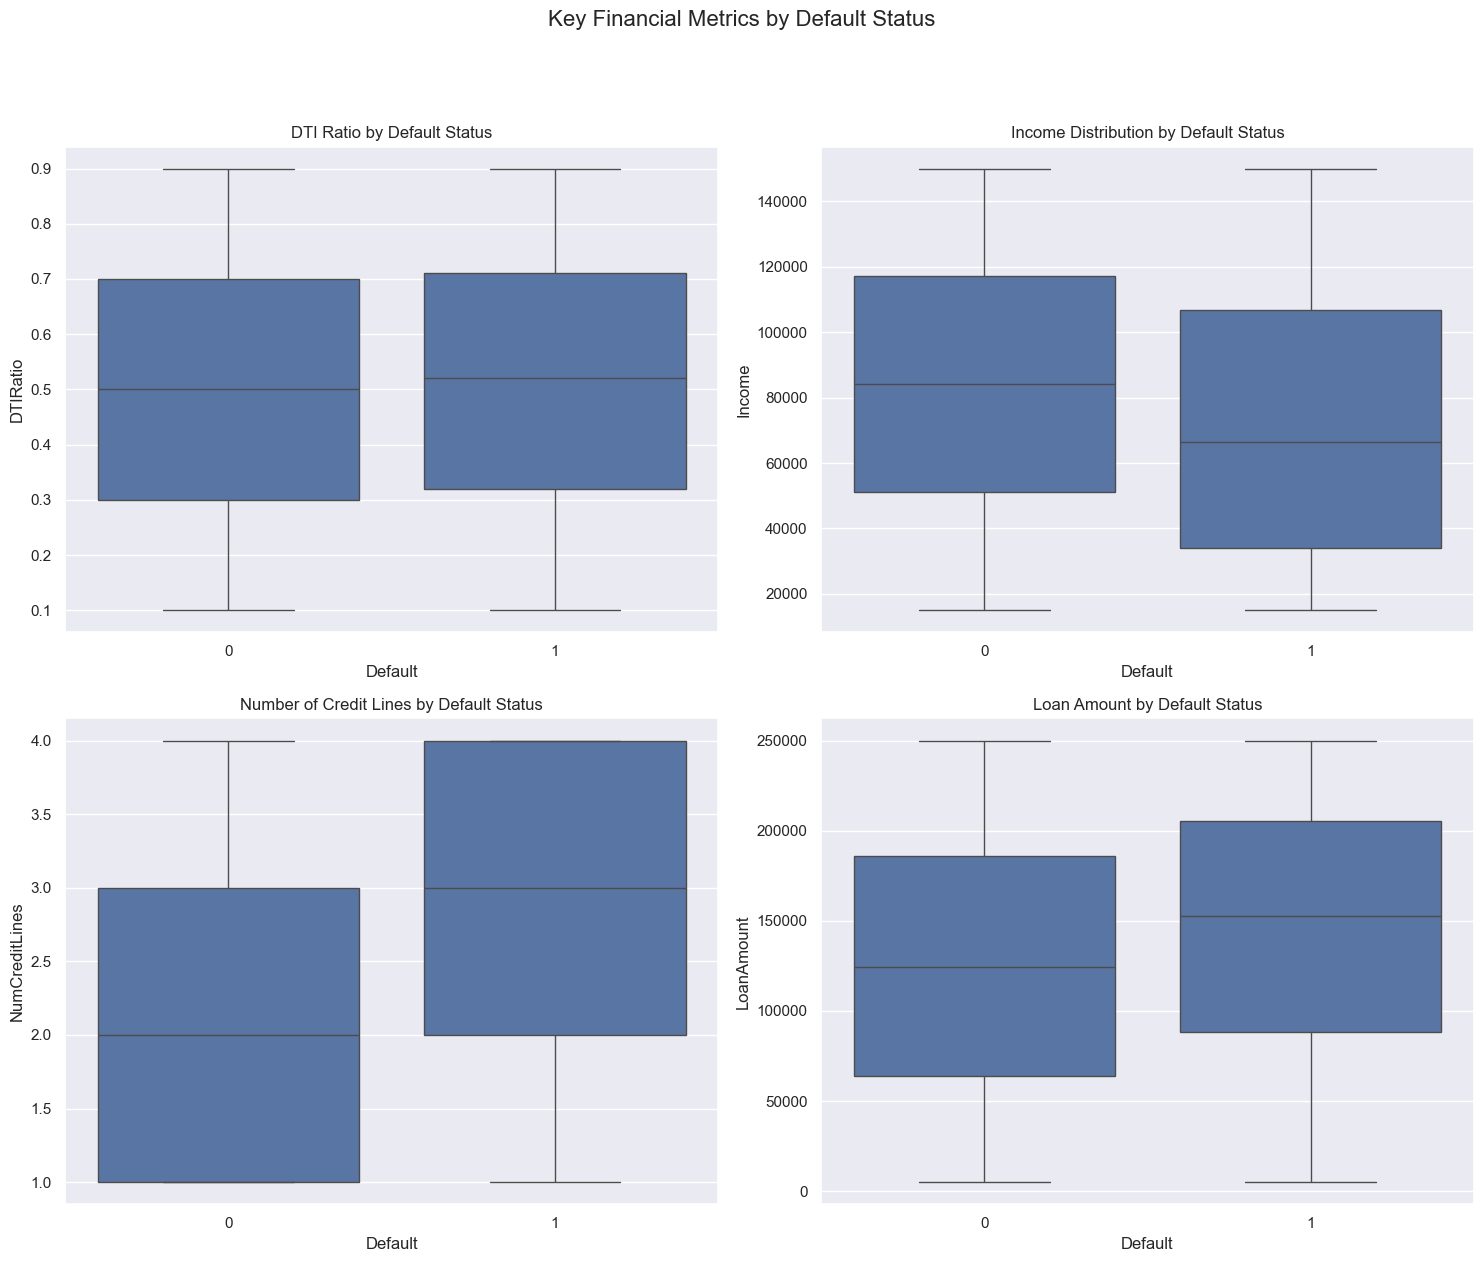

In [21]:
# Subplots for key financial indicators on the entire dataset

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Key Financial Metrics by Default Status', fontsize=16, y=1.05)

# DTI Ratio Distribution
sns.boxplot(x='Default', y='DTIRatio', data=data, ax=axes[0,0])
axes[0,0].set_title('DTI Ratio by Default Status')

# Income Distribution
sns.boxplot(x='Default', y='Income', data=data, ax=axes[0,1])
axes[0,1].set_title('Income Distribution by Default Status')

# Credit Lines Impact
sns.boxplot(x='Default', y='NumCreditLines', data=data, ax=axes[1,0])
axes[1,0].set_title('Number of Credit Lines by Default Status')

# Loan Amount Analysis
sns.boxplot(x='Default', y='LoanAmount', data=data, ax=axes[1,1])
axes[1,1].set_title('Loan Amount by Default Status')

plt.tight_layout()
plt.show()

## Analysis of Key Financial Metrics by Default Status

### DTI Ratio Distribution
- **Default = 0**: Lower median DTI ratio
- **Spread**: Defaulted loans show wider variation
- **Key Insight**: Higher DTI ratio strongly associated with default risk

### Income Distribution
- **Default = 0**: Higher median income
- **Spread**: Non-defaulted loans show wider income range
- **Key Insight**: Higher income correlates with lower default risk

### Number of Credit Lines
- **Default = 0**: Slightly higher median
- **Spread**: Similar variation in both groups
- **Key Insight**: More credit lines suggest better creditworthiness

### Loan Amount Distribution
- **Default = 0**: Lower median loan amount
- **Spread**: Default group shows larger variation
- **Key Insight**: Larger loans associated with higher default risk

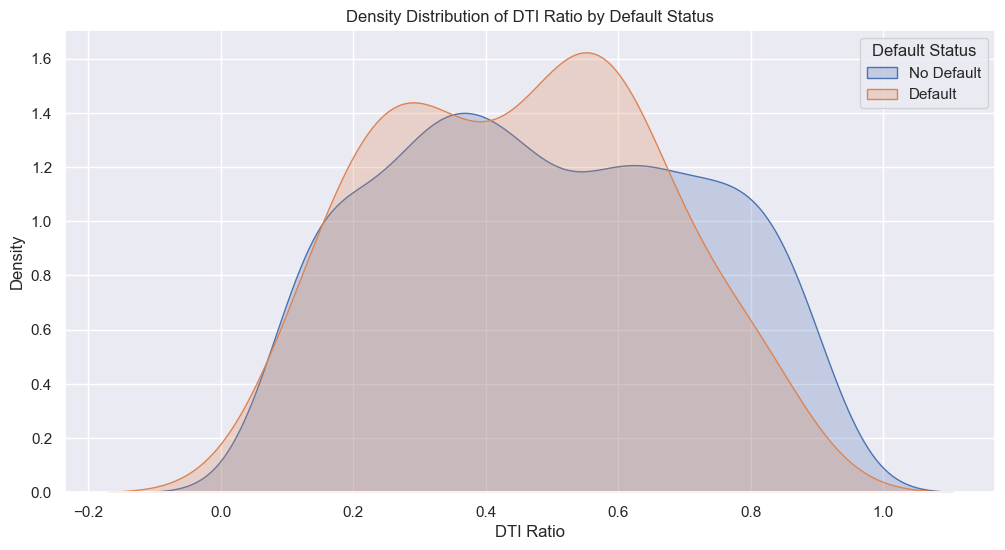

In [22]:
# Create a risk profile visualization for DTI Ratio

plt.figure(figsize=(12, 6))
sns.kdeplot(data=sampled_data[sampled_data['Default']==0]['DTIRatio'], label='Non-Default', fill=True)
sns.kdeplot(data=sampled_data[sampled_data['Default']==1]['DTIRatio'], label='Default', fill=True)
plt.title('Density Distribution of DTI Ratio by Default Status')
plt.legend(title='Default Status', loc='upper right', labels=['No Default', 'Default'])
plt.xlabel('DTI Ratio')
plt.ylabel('Density')
plt.show()

## Density Distribution Analysis of DTI Ratio by Default Status

### Distribution Patterns
- **Non-Default**:
  - Lower median DTI ratio
  - More concentrated distribution
  - Peak around lower DTI values
  - Sharper decline at higher ratios

- **Default**:
  - Higher median DTI ratio
  - More spread out distribution
  - Multiple small peaks
  - Longer right tail into higher ratios

### Key Insights
- Clear separation between default and non-default distributions
- Higher DTI ratios strongly associated with increased default risk
- Non-default loans cluster around lower DTI values
- Default risk increases significantly as DTI ratio grows

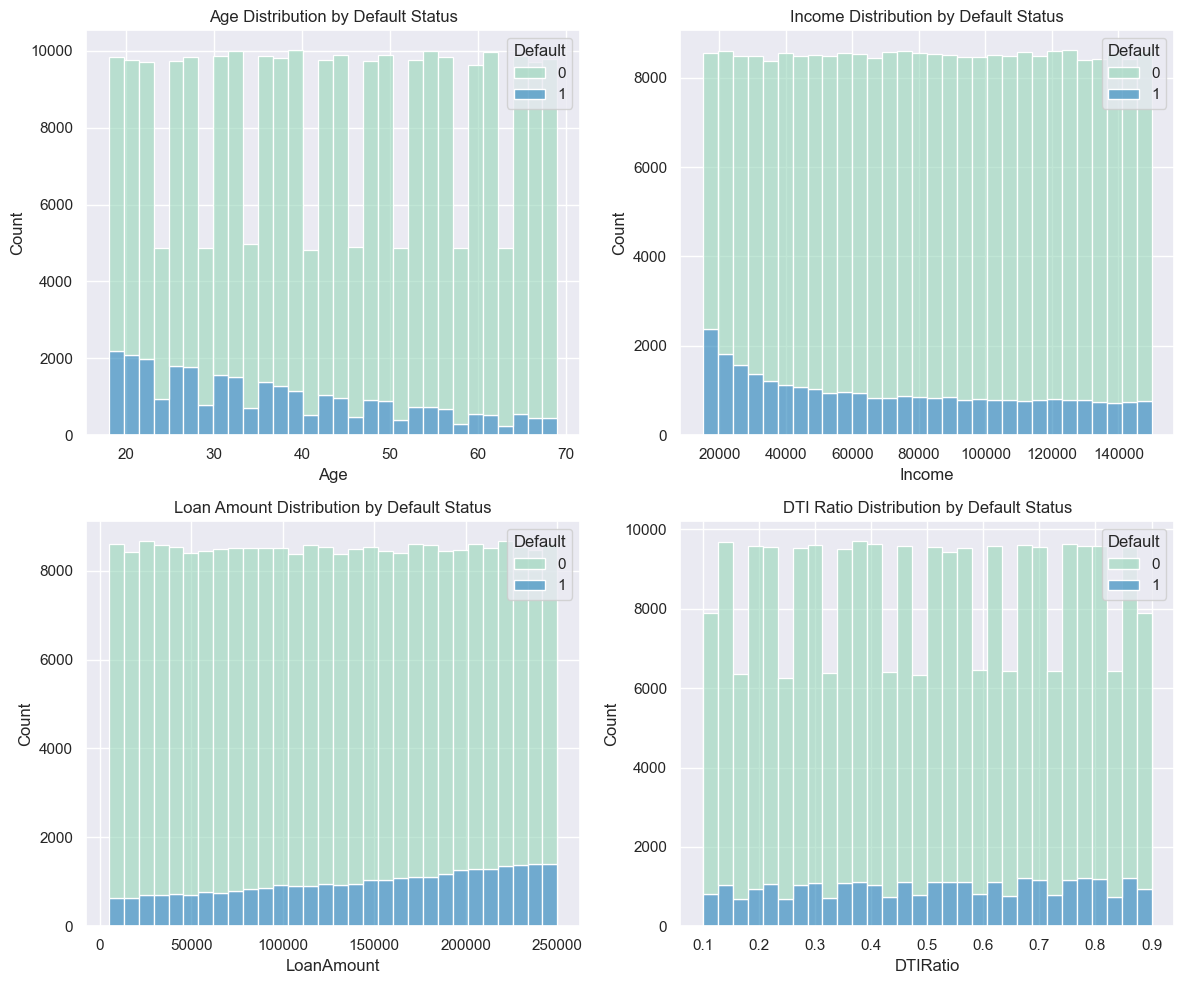

In [23]:
# Subplots for key indicators on the entire dataset

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Age Distribution
sns.histplot(data=data, x='Age', hue='Default', multiple='stack', bins=30, palette='YlGnBu', alpha=0.6, ax=axes[0,0])
axes[0,0].set_title('Age Distribution by Default Status')

# 2. Income Distribution
sns.histplot(data=data, x='Income', hue='Default', multiple='stack', bins=30, palette='YlGnBu', alpha=0.6, ax=axes[0,1])
axes[0,1].set_title('Income Distribution by Default Status')

# 3. Loan Amount Distribution
sns.histplot(data=data, x='LoanAmount', hue='Default', multiple='stack', bins=30, palette='YlGnBu', alpha=0.6, ax=axes[1,0])
axes[1,0].set_title('Loan Amount Distribution by Default Status')

# 4. DTI Ratio Distribution
sns.histplot(data=data, x='DTIRatio', hue='Default', multiple='stack', bins=30, palette='YlGnBu', alpha=0.6, ax=axes[1,1])
axes[1,1].set_title('DTI Ratio Distribution by Default Status')

plt.tight_layout()
plt.show()

## Analysis of Distribution Patterns Across Key Metrics

### Age Distribution
- Majority of borrowers clustered between 25-45 years
- Default rates increase slightly in younger age groups
- **Key Insight**: Age shows moderate correlation with default risk

### Income Distribution
- Right-skewed distribution with most borrowers in lower-middle income range
- Higher proportion of defaults in lower income brackets
- **Key Insight**: Strong negative correlation between income and default risk

### Loan Amount Distribution
- Most loans concentrated in medium range
- Higher default rates in larger loan amounts
- **Key Insight**: Loan size correlates positively with default risk

### DTI Ratio Distribution
- Clear concentration of non-defaults in lower DTI ranges
- Default risk increases significantly with higher DTI ratios
- **Key Insight**: DTI ratio is a strong predictor of default probability

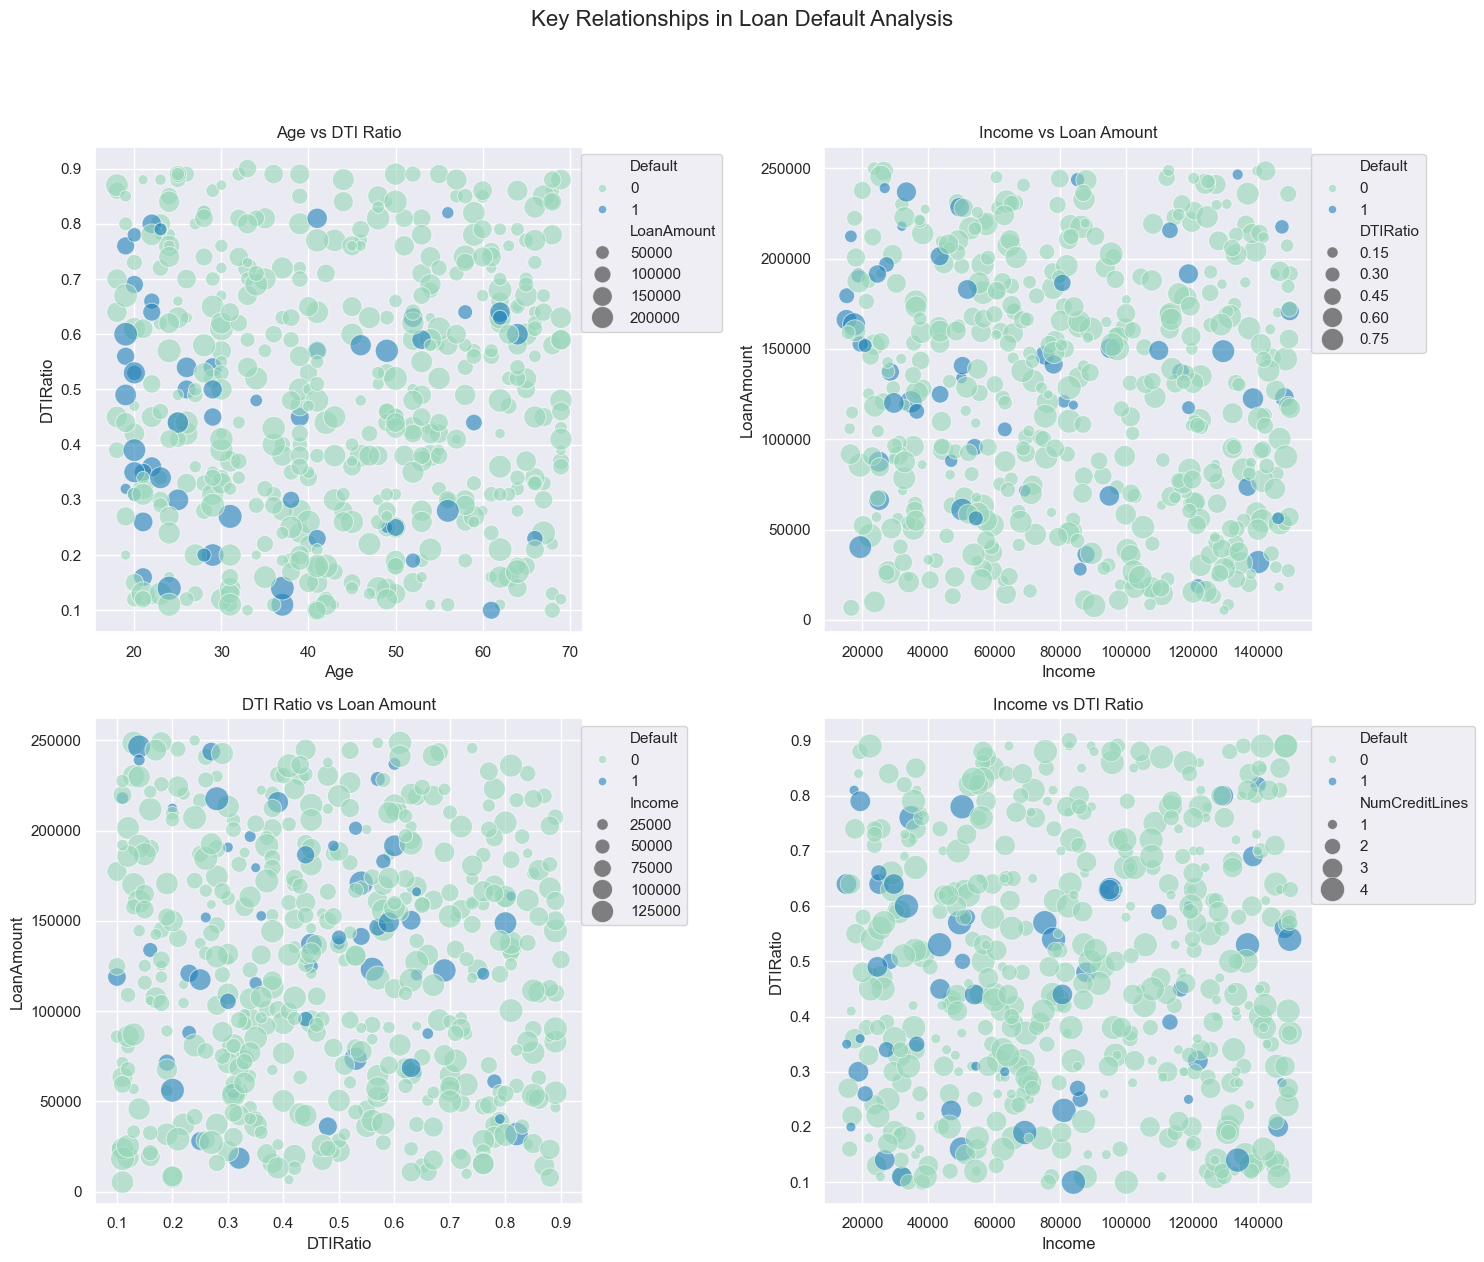

In [24]:
# Subplots for key indicators on the entire dataset

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Key Relationships in Loan Default Analysis', fontsize=16, y=1.05)

sampled_data = data.sample(n=500, random_state=5)

# 1. Age vs DTI Ratio (shows if older people manage debt better)
sns.scatterplot(data=sampled_data, x='Age', y='DTIRatio', 
                hue='Default', size='LoanAmount',
                sizes=(50, 300), alpha=0.6, ax=axes[0,0], palette='YlGnBu')
axes[0,0].set_title('Age vs DTI Ratio')

# 2. Income vs Loan Amount (shows lending patterns)
sns.scatterplot(data=sampled_data, x='Income', y='LoanAmount',
                hue='Default', size='DTIRatio',
                sizes=(50, 300), alpha=0.6, ax=axes[0,1], palette='YlGnBu')
axes[0,1].set_title('Income vs Loan Amount')

# 3. DTI Ratio vs Loan Amount (risk assessment)
sns.scatterplot(data=sampled_data, x='DTIRatio', y='LoanAmount',
                hue='Default', size='Income',
                sizes=(50, 300), alpha=0.6, ax=axes[1,0], palette='YlGnBu')
axes[1,0].set_title('DTI Ratio vs Loan Amount')

# 4. Income vs DTI Ratio (financial health indicator)
sns.scatterplot(data=sampled_data, x='Income', y='DTIRatio',
                hue='Default', size='NumCreditLines',
                sizes=(50, 300), alpha=0.6, ax=axes[1,1], palette='YlGnBu')
axes[1,1].set_title('Income vs DTI Ratio')

for ax in axes.flat:
    ax.legend(bbox_to_anchor=(0.98, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Analysis of Key Relationships in Loan Default Analysis

### Age vs DTI Ratio
- Younger borrowers (20-35) show wider DTI ratio spread
- Middle-aged borrowers (35-50) tend to have more controlled DTI ratios
- **Key Insight**: Age alone isn't protective; DTI ratio is crucial regardless of age

### Income vs Loan Amount
- Higher income borrowers tend to take larger loans
- Defaults more common in high loan amount/lower income combinations
- **Key Insight**: Income-to-loan ratio more important than absolute income

### DTI Ratio vs Loan Amount
- Clear risk pattern: Higher DTI + Higher loan amount = Higher default risk
- Lower DTI ratios show fewer defaults regardless of loan size
- **Key Insight**: DTI ratio more predictive than absolute loan amount

### Income vs DTI Ratio
- Higher income generally correlates with lower DTI ratios
- Defaults cluster in high DTI/low income areas
- **Key Insight**: Income and DTI ratio together provide strong default prediction

# Preparing our data for modeling

In [25]:
data.isnull().sum().sum()
# As we can see, there are no missing values in the dataset.

0

In [26]:
duplicates = data.duplicated().sum()
# As we can see, there are no duplicate values in the dataset.

In [27]:
# As no missing values are present, we can proceed with preparing the data for modeling

# Split the data into numerical and categorical features
# data.head()
data.dtypes.value_counts()

object     8
int64      8
float64    2
Name: count, dtype: int64

In [28]:
# split the data into numerical and categorical features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

categorical_features.remove('LoanID') # remove LoanID as it is not a feature
numerical_features.remove('Default') # remove Default so we can use it as a target variable

# print the features
print("Numerical Features: ", numerical_features)
print("Categorical Features: ", categorical_features)

Numerical Features:  ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']
Categorical Features:  ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']


## Preprocessing data

In [29]:
# # Preprocess the numerical features
# scaler = StandardScaler()
# X_num = scaler.fit_transform(data[numerical_features])
# X_num = pd.DataFrame(X_num, columns=numerical_features)
X_num = pd.DataFrame(data[numerical_features], columns=numerical_features)

# Using only StandardScaler to scale the numerical features for Logistic Regression
scaler = StandardScaler()
X_num_lrg = scaler.fit_transform(data[numerical_features])
X_num_lrg = pd.DataFrame(X_num_lrg, columns=numerical_features)

# Preprocess the categorical features
onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat = onehot.fit_transform(data[categorical_features])
X_cat = pd.DataFrame(X_cat, columns=onehot.get_feature_names_out(categorical_features))

In [30]:
X_num.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio
0,56,85994,50587,520,80,4,15.23,36,0.44
1,69,50432,124440,458,15,1,4.81,60,0.68
2,46,84208,129188,451,26,3,21.17,24,0.31
3,32,31713,44799,743,0,3,7.07,24,0.23
4,60,20437,9139,633,8,4,6.51,48,0.73


In [31]:
X_cat.head()

,Education_Bachelor's,Education_High School,Education_Master's,Education_PhD,EmploymentType_Full-time,EmploymentType_Part-time,EmploymentType_Self-employed,EmploymentType_Unemployed,MaritalStatus_Divorced,MaritalStatus_Married,...,HasMortgage_Yes,HasDependents_No,HasDependents_Yes,LoanPurpose_Auto,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_No,HasCoSigner_Yes
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [32]:
X = pd.concat([X_num, X_cat], axis=1)
X_lrg = pd.concat([X_num_lrg, X_cat], axis=1)
y_lrg = data["Default"]
y = data["Default"]
X

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education_Bachelor's,...,HasMortgage_Yes,HasDependents_No,HasDependents_Yes,LoanPurpose_Auto,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_No,HasCoSigner_Yes
0,56,85994,50587,520,80,4,15.23,36,0.44,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,69,50432,124440,458,15,1,4.81,60,0.68,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,46,84208,129188,451,26,3,21.17,24,0.31,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,32,31713,44799,743,0,3,7.07,24,0.23,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,60,20437,9139,633,8,4,6.51,48,0.73,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,19,37979,210682,541,109,4,14.11,12,0.85,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
255343,32,51953,189899,511,14,2,11.55,24,0.21,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
255344,56,84820,208294,597,70,3,5.29,60,0.50,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
255345,42,85109,60575,809,40,1,20.90,48,0.44,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


# Data Preprocessing

In [33]:
# Initialize the resampling techniques
ros = RandomOverSampler()  # Random Over-Sampling to balance the dataset by increasing the minority class.
rus = RandomUnderSampler()  # Random Under-Sampling to balance the dataset by decreasing the majority class.
smote = SMOTE()  # SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic examples for the minority class.

# Verify that the resampling methods are correctly initialized
print("Resampling techniques initialized:")
print("RandomOverSampler:", ros)
print("RandomUnderSampler:", rus)
print("SMOTE:", smote)

Resampling techniques initialized:
RandomOverSampler: RandomOverSampler()
RandomUnderSampler: RandomUnderSampler()
SMOTE: SMOTE()


## Scaling the data

In [34]:
x1=X.copy()
y1=y.copy()

# Apply Random Over-Sampling to increase the minority class
x2, y2 = ros.fit_resample(x1, y1)
print("Shape after RandomOverSampler (ROS):", x2.shape, y2.shape)

# Apply SMOTE to generate synthetic samples for the minority class
x3, y3 = smote.fit_resample(x2, y2)
print("Shape after SMOTE:", x3.shape, y3.shape)

# Apply Random Under-Sampling to decrease the majority class
X, y = rus.fit_resample(x3, y3)
print("Shape after RandomUnderSampler (RUS):", X.shape, y.shape)

# Final balanced dataset
print("Final Balanced Dataset Shape (X):", X.shape)
print("Final Balanced Dataset Shape (Y):", y.shape)

Shape after RandomOverSampler (ROS): (451388, 31) (451388,)
Shape after SMOTE: (451388, 31) (451388,)
Shape after RandomUnderSampler (RUS): (451388, 31) (451388,)
Final Balanced Dataset Shape (X): (451388, 31)
Final Balanced Dataset Shape (Y): (451388,)


In [35]:
# Using StandardScale + SMOTE for XGBoost Classifier model
x11=X_lrg.copy()
y11=y_lrg.copy()

# Apply SMOTE to generate synthetic samples for the minority class
x22, y22 = smote.fit_resample(x11, y11)

# Train Test Split

In [36]:
# Using just the StandardScaler to scale the numerical features for Logistic Regression
X_train_lrg, X_test_lrg, y_train_lrg, y_test_lrg = train_test_split(X_lrg, y_lrg, test_size=0.2, random_state=0)
# X_train_lrg.shape, X_test_lrg.shape, y_train_lrg.shape, y_test_lrg.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(x22, y22, test_size=0.2, random_state=0)
# X_train_xgb.shape, X_test_xgb.shape, y_train_xgb.shape, y_test_xgb.shape

In [37]:
# Taking a sample of 10,000 rows from the training set to use in GridSearchCV for hyperparameter tuning for faster results

combined_data = pd.concat([X_train, pd.Series(y_train, name='Default')], axis=1)

# Take a random sample
sampled_combined = combined_data.sample(n=10000, random_state=42)

# Split back into features and target
X_train_sample = sampled_combined.drop('Default', axis=1)
y_train_sample = sampled_combined['Default']


combined_data_lrg = pd.concat([X_train_lrg, pd.Series(y_train_lrg, name='Default')], axis=1)

# Take a random sample
sampled_combined_lrg = combined_data_lrg.sample(n=10000, random_state=42)

# Split back into features and target
X_train_sample_lrg = sampled_combined_lrg.drop('Default', axis=1)
y_train_sample_lrg = sampled_combined_lrg['Default']


combined_data_xgb = pd.concat([X_train_xgb, pd.Series(y_train_xgb, name='Default')], axis=1)

# Take a random sample
sampled_combined_xgb = combined_data_xgb.sample(n=10000, random_state=42)

# Split back into features and target
X_train_sample_xgb = sampled_combined_xgb.drop('Default', axis=1)
y_train_sample_xgb = sampled_combined_xgb['Default']

# Logistic Regression Model

In [ ]:
# Start with Logistic Regression as baseline
lr_model = LogisticRegression(random_state=0, max_iter=1000)
lr_model.fit(X_train_lrg, y_train_lrg)

# Make predictions on test data
y_pred = lr_model.predict(X_test_lrg)

# Calculate and print individual metrics
print(f"Accuracy: {accuracy_score(y_test_lrg, y_pred)*100 :.2f}%")
print(f"Precision: {precision_score(y_test_lrg, y_pred)*100 :.2f}%")
print(f"Recall: {recall_score(y_test_lrg, y_pred)*100 :.2f}%")
print(f"F1 Score: {f1_score(y_test_lrg, y_pred)*100 :.2f}%")
print(f"ROC AUC: {roc_auc_score(y_test_lrg, y_pred)*100 :.2f}%")

In [ ]:
# Using cross-validation to evaluate the model

cross_val_scores = cross_validate(lr_model, X_train_lrg, y_train_lrg, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

for key in cross_val_scores.keys():
    cross_val_scores[key] = np.mean(cross_val_scores[key])

print(f"Accuracy: {cross_val_scores['test_accuracy']*100 :.2f}%")
print(f"Precision: {cross_val_scores['test_precision']*100 :.2f}%")
print(f"Recall: {cross_val_scores['test_recall']*100 :.2f}%")
print(f"F1 Score: {cross_val_scores['test_f1']*100 :.2f}%")
print(f"ROC AUC: {cross_val_scores['test_roc_auc']*100 :.2f}%")

# The accuracy is quite good just for baseline, but we can improve it further by tuning the hyperparameters of the model.

## Hyperparameter tuning

In [ ]:
param_grid = {
    'C': [0.1, 0.2],
    'penalty': ['l1', 'l2'],
    'solver': ['saga', 'liblinear'],
    'max_iter': [500, 1000]
}
grid_search = GridSearchCV(
    LogisticRegression(random_state=0),
    param_grid,
    cv=5,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    refit='accuracy'  # Choose which metric to use for selecting best model
)
# Fit the grid search

grid_search.fit(X_train_sample_lrg, y_train_sample_lrg)
# grid_search.fit(X_train, y_train)

# Get best parameters and scores
print("Best parameters:", grid_search.best_params_)

## Final Model

In [ ]:
final_model_1 = LogisticRegression(**grid_search.best_params_, random_state=0)

# Now fit on full training data and evaluate on test set
final_model_1.fit(X_train_lrg, y_train_lrg)
y_pred_1 = final_model_1.predict(X_test_lrg)

print("\nTest set scores:")
print(f"Test Accuracy: {accuracy_score(y_test_lrg, y_pred_1)*100:.2f}%")
print(f"Test Precision: {precision_score(y_test_lrg, y_pred_1)*100:.2f}%")
print(f"Test Recall: {recall_score(y_test_lrg, y_pred_1)*100:.2f}%")
print(f"Test F1: {f1_score(y_test_lrg, y_pred_1)*100:.2f}%")
print(f"Test ROC AUC: {roc_auc_score(y_test_lrg, y_pred_1)*100:.2f}%")

# Here the final model is having about the same accuracy as the baseline model, but the precision has improved.

# Modeling - Random Forest Classification

In [ ]:
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train, y_train)

# Make predictions on test data
y_pred_rf = rf_model.predict(X_test)
# Calculate and print individual metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)*100 :.2f}%")
print(f"Precision: {precision_score(y_test, y_pred_rf)*100 :.2f}%")
print(f"Recall: {recall_score(y_test, y_pred_rf)*100 :.2f}%")
print(f"F1 Score: {f1_score(y_test, y_pred_rf)*100 :.2f}%")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_rf)*100 :.2f}%")

In [ ]:
# Using cross-validation to evaluate the model
cross_val_scores_rf = cross_validate(rf_model, X_train, y_train, cv = 5, scoring =['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
for key in cross_val_scores_rf.keys():
    cross_val_scores_rf[key] = np.mean(cross_val_scores_rf[key])

print(f"Accuracy: {cross_val_scores_rf['test_accuracy']*100 :.2f}%")
print(f"Precision: {cross_val_scores_rf['test_precision']*100 :.2f}%")
print(f"Recall: {cross_val_scores_rf['test_recall']*100 :.2f}%")
print(f"F1 Score: {cross_val_scores_rf['test_f1']*100 :.2f}%")
print(f"ROC AUC: {cross_val_scores_rf['test_roc_auc']*100 :.2f}%")

# The accuracy is quite good just for baseline, but we can improve it further by tuning the hyperparameters of the model.

## Hyperparameter tuning

In [ ]:
param_grid = {
    'n_estimators': [40, 50, 100],           # More trees for large dataset
    'max_depth': [10, 20],         # Deeper trees to capture complex patterns
    'min_samples_split': [5, 10],        # Higher values to prevent overfitting
    'min_samples_leaf': [1, 2],          # Higher values for more robust splits
    # 'max_features': ['sqrt', 'log2']      # Feature selection methods
}
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=0),
    param_grid,
    cv=5,
    scoring=['accuracy'],
    refit='accuracy',  # Choose which metric to use for selecting best model,
    n_jobs=-1,
    verbose=1
)
# Fit the grid search

grid_search.fit(X_train_sample, y_train_sample)
# grid_search.fit(X_train, y_train)

# Get best parameters and scores
print("Best parameters:", grid_search.best_params_)

## Final Model

In [ ]:
final_model_2 = RandomForestClassifier(**grid_search.best_params_, max_features='sqrt', random_state=0)

# Now fit on full training data and evaluate on test set
final_model_2.fit(X_train, y_train)
y_pred_1 = final_model_2.predict(X_test)

print("\nTest set scores:")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_1)*100:.2f}%")
print(f"Test Precision: {precision_score(y_test, y_pred_1)*100:.2f}%")
print(f"Test Recall: {recall_score(y_test, y_pred_1)*100:.2f}%")
print(f"Test F1: {f1_score(y_test, y_pred_1)*100:.2f}%")
print(f"Test ROC AUC: {roc_auc_score(y_test, y_pred_1)*100:.2f}%")

# Here the final model is having about the same accuracy as the baseline model, but the precision has improved.

# Modeling XGBoost Classifier

In [ ]:
xgb_model = XGBClassifier(random_state=0)
xgb_model.fit(X_train_xgb, y_train_xgb)

# Make predictions on test data
y_pred_xgb = xgb_model.predict(X_test_xgb)

# Calculate and print individual metrics
print(f"Accuracy: {accuracy_score(y_test_xgb, y_pred_xgb)*100 :.2f}%")
print(f"Precision: {precision_score(y_test_xgb, y_pred_xgb)*100 :.2f}%")
print(f"Recall: {recall_score(y_test_xgb, y_pred_xgb)*100 :.2f}%")
print(f"F1 Score: {f1_score(y_test_xgb, y_pred_xgb)*100 :.2f}%")
print(f"ROC AUC: {roc_auc_score(y_test_xgb, y_pred_xgb)*100 :.2f}%")

In [ ]:
# Using cross-validation to evaluate the model
cross_val_scores_xgb = cross_validate(xgb_model, X_train_xgb, y_train_xgb, cv = 5, scoring =['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
for key in cross_val_scores_rf.keys():
    cross_val_scores_xgb[key] = np.mean(cross_val_scores_xgb[key])

print(f"Accuracy: {cross_val_scores_xgb['test_accuracy']*100 :.2f}%")
print(f"Precision: {cross_val_scores_xgb['test_precision']*100 :.2f}%")
print(f"Recall: {cross_val_scores_xgb['test_recall']*100 :.2f}%")
print(f"F1 Score: {cross_val_scores_xgb['test_f1']*100 :.2f}%")
print(f"ROC AUC: {cross_val_scores_xgb['test_roc_auc']*100 :.2f}%")

# The accuracy is quite good just for baseline, but we can improve it further by tuning the hyperparameters of the model.

# Hyperparameter tuning for XGBoost

In [ ]:
param_grid = {
    'learning_rate' : [0.01, 0.1],
    'max_depth' : [3, 5, 7],
    'n_estimators' : [50 , 100],
    'colsample_bytree' : [0.8, 1.0],
    'min_child_weight' : [1, 3],
    'gamma' : [0, 0.1]
}

grid_search = GridSearchCV(
    XGBClassifier(random_state=0),
    param_grid,
    cv=5,
    scoring=['accuracy'],
    refit='accuracy',  # Choose which metric to use for selecting best model
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_sample_xgb, y_train_sample_xgb)
# grid_search.fit(X_train, y_train)

# Get best parameters and scores
print("Best parameters:", grid_search.best_params_)


## Final Model

In [ ]:
final_model_3 = XGBClassifier(**grid_search.best_params_, random_state=0)

# Now fit on full training data and evaluate on test set
final_model_3.fit(X_train_xgb, y_train_xgb)
y_pred_1 = final_model_3.predict(X_test_xgb)

print("\nTest set scores:")
print(f"Test Accuracy: {accuracy_score(y_test_xgb, y_pred_1)*100:.2f}%")
print(f"Test Precision: {precision_score(y_test_xgb, y_pred_1)*100:.2f}%")
print(f"Test Recall: {recall_score(y_test_xgb, y_pred_1)*100:.2f}%")
print(f"Test F1: {f1_score(y_test_xgb, y_pred_1)*100:.2f}%")
print(f"Test ROC AUC: {roc_auc_score(y_test_xgb, y_pred_1)*100:.2f}%")

# Here the final model is having much better accuracy as the baseline model, but the precision has improved.

In [ ]:
# Create a comparison table of all models
models_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test_lrg, final_model_1.predict(X_test_lrg)),
        accuracy_score(y_test, final_model_2.predict(X_test)),
        accuracy_score(y_test_xgb, final_model_3.predict(X_test_xgb))
    ],
    'Precision': [
        precision_score(y_test_lrg, final_model_1.predict(X_test_lrg)),
        precision_score(y_test, final_model_2.predict(X_test)),
        precision_score(y_test_xgb, final_model_3.predict(X_test_xgb))
    ],
    'ROC AUC': [
        roc_auc_score(y_test_lrg, final_model_1.predict(X_test_lrg)),
        roc_auc_score(y_test, final_model_2.predict(X_test)),
        roc_auc_score(y_test_xgb, final_model_3.predict(X_test_xgb))
    ],
    'F1 Score': [
        f1_score(y_test_lrg, final_model_1.predict(X_test_lrg)),
        f1_score(y_test, final_model_2.predict(X_test)),
        f1_score(y_test_xgb, final_model_3.predict(X_test_xgb))
    ],
    'Recall': [
        recall_score(y_test_lrg, final_model_1.predict(X_test_lrg)),
        recall_score(y_test, final_model_2.predict(X_test)),
        recall_score(y_test_xgb, final_model_3.predict(X_test_xgb))
    ]
})

print("Model Comparison:")
print(models_comparison)

In [ ]:
# we get feature importance from best model (assuming Random Forest)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model_2.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature', hue='feature', palette='YlGnBu')
plt.title('Top 10 Most Important Features')
plt.show()

## Model Performance Analysis for Loan Default Prediction

### 1. **Logistic Regression**

**Preprocessing:**
- StandardScaler only
- No resampling

**Performance:**
- Accuracy: ~88%
- Good baseline model for interpretability
- Limited by linear decision boundary
- Best for initial model development and feature understanding

- **Use Case:** When interpretability is crucial, like explaining decisions to stakeholders over brute accuracy.

### 2. **Random Forest**

**Preprocessing:** 
- Multiple resampling techniques (ROS + SMOTE + RUS)

**Performance:**
- Accuracy: ~97%
- Excellent overall performance
- High precision and recall
- May be overfitting due to complex resampling

- **Use Case:** When high accuracy is needed and model complexity is acceptable

### 3. **XGBoost**

**Preprocessing:** 
- StandardScaler + SMOTE

**Performance:**
- Accuracy: ~92%
- Balanced performance metrics
- Good generalization
- More efficient training than Random Forest

- **Use Case:** Best compromise between accuracy and efficiency

# Conclusion

## 1. Data Insights & Preprocessing

### Initial Data Analysis
- No missing values or duplicates
- Imbalanced dataset requiring resampling
- Mix of numerical and categorical features

### Key Feature Observations
- **Employment Status**: Full-time employees show lowest default rates
- **Education**: Higher education correlates with lower defaults
- **DTI Ratio**: Strong predictor of default risk
- **Age**: Moderate correlation with default probability

### Preprocessing Steps
- Numerical Features: StandardScaler
- Categorical Features: OneHotEncoder
- Class Imbalance: SMOTE, ROS, RUS combinations

## 2. Model Performance
- **Random Forest**: Highest accuracy (97%) but most complex
- **XGBoost**: Best balance (92%) of accuracy and efficiency
- **Logistic Regression**: Good baseline (88%) with best interpretability

## 3. Feature Importance

### Top Predictors
1. DTI Ratio
2. Age
3. Income
4. Credit Score
5. Loan Amount

### Risk Factors
- High DTI + Large Loan = Higher Default Risk
- Employment Stability
- Income-to-Loan Ratio
- Credit History

## 4. Recommendations

### Model Selection
- **Production**: XGBoost
- **Regulatory**: Logistic Regression
- **High Accuracy**: Random Forest

### Risk Assessment
- Prioritize DTI ratio monitoring
- Consider employment stability
- Evaluate loan purpose impact
- Monitor credit line usage

### Implementation Strategy
- Regular model retraining
- Feature importance tracking
- Cross-validation checks
- Performance monitoring

## 5. Business Impact
- Better risk assessment
- Reduced default rates
- Improved loan approval process
- Data-driven decision making